# Offensive Language Detection using Backpropagation

## Topic

The dataset for this project is obtained from twitter and contains instances of hate speech, offensive language and neither. Seen as I wanted to try with binary classification I will only use the offensive speech and the non offensive to create two classes for the target. The dataset contains labeled text which I will first process and then train a simple neural network to capture the difference between the two kinds of speechs.

## Objective

- Build a classifier that can detect offensive speech

## Summary

- Importing libraries
- The dataset
- Converting characters to lower case
- removing punctuation
- Removing digits
- Tokenizing sentences
- Removing stopwords
- Removing frequent words
- Stemming
- bag of words
- Train/Test split
- Creating train/test loaders
- Building the classifier
- Training and inference
- Trying out the model
- Conclusion


### Importing libraries

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import numpy as np 
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import coo_matrix
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import string
from nltk import FreqDist
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### The Dataset

In [54]:
df = pd.read_csv(r'C:\Users\imane\Downloads\archive (10)\labeled_data.csv', sep =",")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [57]:
df = df.drop(columns=["Unnamed: 0", "count", "hate_speech","offensive_language","neither"], axis = 1)

In [58]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: >

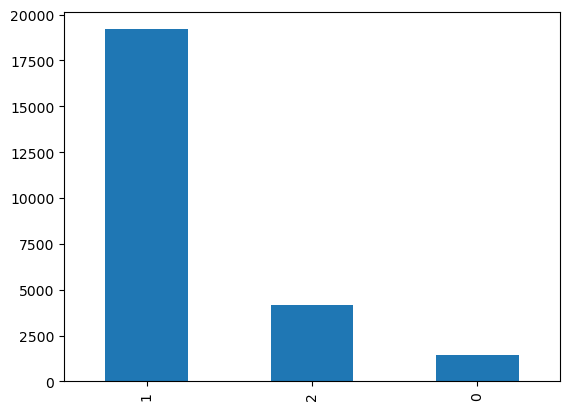

In [59]:
df['class'].value_counts().plot(kind='bar')

In [60]:
df.drop(df[df['class'] == 0].index, inplace = True)

In [61]:
df =df.replace(2,0)

In [62]:
df["class"].value_counts()

1    19190
0     4163
Name: class, dtype: int64

In [63]:
one = df[df["class"] == 1]
one = one.reset_index(drop=True)

In [64]:
zero = df[df["class"] == 0]
zero = zero.reset_index(drop=True)

In [65]:
one = one.iloc[:2000]
zero = zero.iloc[:2000]

In [66]:
data = pd.concat([one, zero], axis =0)
data = data.sample(frac=1)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 650 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   4000 non-null   int64 
 1   tweet   4000 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.8+ KB


In [68]:
target = data["class"]

In [69]:
data = data.drop(columns="class", axis =1)

In [70]:
target.head()

650     0
468     0
1870    0
810     1
1941    1
Name: class, dtype: int64

The dataset contains instance of hate speech labeled as 0, offensive language as 1 and neither is 2. Seen as I wanted to try binary classification, I only kept offensive language and neither and changed the label of neither to 0 instead of 1. Next, since the dataset is huge I decided to keep only 2000 instances per class because I will be using bag of words later and if I have many instances I will end up with a huge neural net that'll take too long to train.

### Converting characters to lower case

In [71]:
data["tweet"] = data["tweet"].str.lower()
data.head()

,tweet
650,@machell1123 i hope you get better soon! colds...
468,@colemcdowell2 waco is ghetto hahaha. wait til...
1870,i used to chug vodka and orange juice. i also ...
810,&#128563;&#128563;&#128563; rt @winterlove___:...
1941,@andreaa_olvera smd bitch


### Removing punctuation

In [72]:
def remove_punct(text):
    text = text.translate(str.maketrans(" "," ", string.punctuation ))
    return text

In [73]:
data["tweet"] = data["tweet"].apply(remove_punct)
data.head()

,tweet
650,machell1123 i hope you get better soon colds a...
468,colemcdowell2 waco is ghetto hahaha wait til w...
1870,i used to chug vodka and orange juice i also u...
810,128563128563128563 rt winterlove 8220thisisyou...
1941,andreaaolvera smd bitch


### Removing digits

In [74]:
def remove_digits(text):
    exclude = text
    return "".join(token for token in text if not token.isdigit())

In [75]:
data["tweet"] = data["tweet"].apply(remove_digits)
data.head()

,tweet
650,machell i hope you get better soon colds are f...
468,colemcdowell waco is ghetto hahaha wait til we...
1870,i used to chug vodka and orange juice i also u...
810,rt winterlove thisisyoungdj every girl got a ...
1941,andreaaolvera smd bitch


### Tokenizing sentences

In [76]:
data["tweet"] = data["tweet"].apply(lambda X: word_tokenize(X))
data.head()

,tweet
650,"[machell, i, hope, you, get, better, soon, col..."
468,"[colemcdowell, waco, is, ghetto, hahaha, wait,..."
1870,"[i, used, to, chug, vodka, and, orange, juice,..."
810,"[rt, winterlove, thisisyoungdj, every, girl, g..."
1941,"[andreaaolvera, smd, bitch]"


### Removing stopwords

In [77]:
stopwords = stopwords.words("english")

In [78]:
def remove_stopwords(text):
    results = []
    for token in text:
        if token not in stopwords:
            results.append(token)
    return results

In [79]:
data["tweet"] = data["tweet"].apply(remove_stopwords)
data.head()

,tweet
650,"[machell, hope, get, better, soon, colds, birds]"
468,"[colemcdowell, waco, ghetto, hahaha, wait, til..."
1870,"[used, chug, vodka, orange, juice, also, used,..."
810,"[rt, winterlove, thisisyoungdj, every, girl, g..."
1941,"[andreaaolvera, smd, bitch]"


### Removing frequent words

In [80]:
def frequent_words(df):
    list = []
    for text in df.values:
        list += text[0]
    frequent = FreqDist(list)
    return frequent.most_common(10)


In [81]:
frequent_words(data)

[('bitch', 769),
 ('like', 401),
 ('trash', 343),
 ('im', 328),
 ('hoes', 278),
 ('pussy', 274),
 ('bitches', 270),
 ('dont', 262),
 ('got', 243),
 ('get', 212)]

In [82]:
frequent = frequent_words(data)
lst = []
for a, b in frequent:
    lst.append(a)

In [83]:
def remove_freq(text):
    result = []
    for item in text:
        if item not in lst:
            result.append(item)
    return result

In [84]:
data["tweet"] = data["tweet"].apply(remove_freq)
data.head()

,tweet
650,"[machell, hope, better, soon, colds, birds]"
468,"[colemcdowell, waco, ghetto, hahaha, wait, til..."
1870,"[used, chug, vodka, orange, juice, also, used,..."
810,"[rt, winterlove, thisisyoungdj, every, girl, w..."
1941,"[andreaaolvera, smd]"


### Stemming

In [85]:
def stem(text):
    stemmer = PorterStemmer()
    results = []
    for word in text:
        results.append(stemmer.stem(word))
    return results

In [86]:
data["tweet"] = data["tweet"].apply(stem)
data.head()

,tweet
650,"[machel, hope, better, soon, cold, bird]"
468,"[colemcdowel, waco, ghetto, hahaha, wait, til,..."
1870,"[use, chug, vodka, orang, juic, also, use, chu..."
810,"[rt, winterlov, thisisyoungdj, everi, girl, wc..."
1941,"[andreaaolvera, smd]"


### Bag of words

In [87]:
vec = CountVectorizer()

In [88]:
text = data["tweet"].map(' '.join)
vec.fit(text)

CountVectorizer()

In [89]:
converted = vec.transform(text)

In [90]:
converted.shape

(4000, 10370)

After processing the textual data, I applied the bag of words to obtain vectors of size 10370 which means that my network will have that many nodes at its input layer. Next I will move to splitting the train and test sets.

### Splitting the training and testing data

In [91]:
X_train, X_test, y_train ,y_test = train_test_split(converted, target, random_state = 42, test_size = 0.25, shuffle = True)

In [92]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [93]:
coo_t = coo_matrix(X_train, dtype= "float32")

In [94]:
values = coo_t.data
indices = np.vstack((coo_t.row, coo_t.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_t.shape

X = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [95]:
coo_v = coo_matrix(X_test, dtype= "float32")

values = coo_v.data
indices = np.vstack((coo_v.row, coo_v.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo_v.shape

Y = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

### Creating train/test loaders

In [96]:
class Train_loader(Dataset):
    def __init__(self):
        self.X = X
        self.Y = torch.tensor(y_train, dtype = torch.float32)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [97]:
class Test_loader(Dataset):
    def __init__(self):
        self.X = Y
        self.Y = torch.tensor(y_test,dtype = torch.float32)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [98]:
train_data = Train_loader()
test_data = Test_loader()

In [99]:
train_loader = DataLoader(dataset = train_data, batch_size= 106)
test_loader = DataLoader(dataset = test_data, batch_size= 106)

In this part I created the train and test loaders, I decided on a batch size of 106 after trying out different batch sizes. 

### Building the classifier

In [100]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10370, 670)
        self.fc2 = nn.Linear(670, 1)
        
        self.dropout = nn.Dropout(p= 0.5)
        self.batchn1 = nn.BatchNorm1d(670)
    
    def forward(self, x):
        
        
        x = self.dropout(F.leaky_relu(self.batchn1(self.fc1(x))))
        
        x = F.sigmoid(self.fc2(x))
        
        return x

In [101]:
classifier = Classifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr= 0.0005)

In this part I build a simple model with only two layers (input, output). I used one node only for the output because it's binary classification with a sigmoid as activation. I also used a dropout of 0.5 and normalization to try and reduce overfitting. The error function I used is Binary Cross Entropy and the Adam optimizer with a very small learning rate.

### Training and inference

In [102]:
epochs = 20
train_loss, test_loss = [], []
train_accuracy, test_accuracy = [],[]
for epoch in range(epochs):
    t_loss = 0
    train_acc = 0
    for sentence, label in train_loader:
        optimizer.zero_grad()
        logits = classifier(sentence)
        label = label.unsqueeze(1)
        loss = criterion(logits, label)
        t_loss += loss.item()
        equals = torch.round(logits) == label
        acc = equals.sum().item()
        train_acc += acc
        loss.backward()
        optimizer.step()
    
    else:
        accuracy = 0
        v_loss = 0
        with torch.no_grad():
            classifier.eval()
            for sentence, label in test_loader:
                logits = classifier(sentence)
                label = label.unsqueeze(1)
                loss = criterion(logits, label)
                v_loss += loss.item()
                equals = torch.round(logits) == label
                acc = equals.sum().item()
                accuracy += acc
        
        train_loss.append(t_loss/len(train_loader.dataset))
        test_loss.append(v_loss/len(test_loader.dataset))
        train_accuracy.append(train_acc /len(train_loader))
        test_accuracy.append(accuracy/len(test_loader))
        classifier.train()
        
        print("Epoch", epoch+1, "Accuracy", accuracy/len(test_loader))

Epoch 1 Accuracy 82.6
Epoch 2 Accuracy 83.8
Epoch 3 Accuracy 83.9
Epoch 4 Accuracy 84.1
Epoch 5 Accuracy 84.3
Epoch 6 Accuracy 84.0
Epoch 7 Accuracy 84.3
Epoch 8 Accuracy 84.4
Epoch 9 Accuracy 84.2
Epoch 10 Accuracy 84.2
Epoch 11 Accuracy 84.0
Epoch 12 Accuracy 83.6
Epoch 13 Accuracy 83.6
Epoch 14 Accuracy 83.5
Epoch 15 Accuracy 83.5
Epoch 16 Accuracy 83.5
Epoch 17 Accuracy 83.4
Epoch 18 Accuracy 83.4
Epoch 19 Accuracy 83.4
Epoch 20 Accuracy 83.5


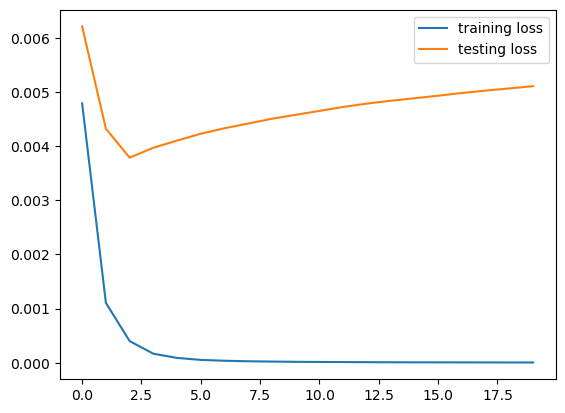

In [103]:
plt.plot(train_loss, label="training loss")
plt.plot(test_loss, label="testing loss")
plt.legend()

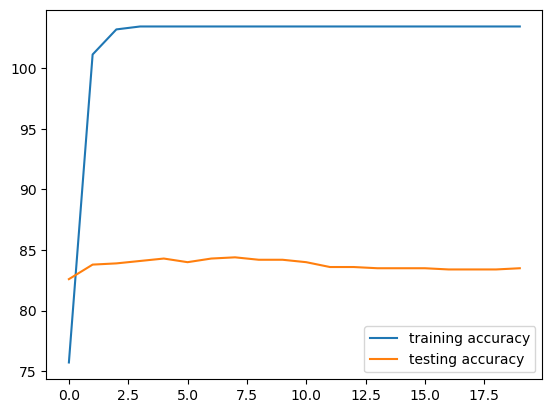

In [104]:
plt.plot(train_accuracy, label="training accuracy")
plt.plot(test_accuracy, label="testing accuracy")
plt.legend()

In the above I did the training of the network through 20 epochs, in each iteration of training I tested the model on a batch of the testing set and kept track of both the accuray and loss. From the plots I can see that my model overfits seen as its testing loss is much higher than training loss and test accuracy if much lower than training accuracy. I can still rely on the model to make accurate predictions during the validation process.

### Trying out the classifier

In [106]:
classifier.eval()
sentence = df["tweet"][19]
print("sentence: ",sentence)
sentence, label = next(iter(train_loader))
s = sentence[19]
s = s.view(1, s.shape[0])
with torch.no_grad():
    output = classifier(s)

print("Actual label", label[19])
print("Model's probabilities: ", output)

sentence:  " black bottle &amp; a bad bitch "
Actual label tensor(1.)
Model's probabilities:  tensor([[1.0000]])


In [111]:
classifier.eval()
sentence = df["tweet"][17]
print("sentence: ",sentence)
sentence, label = next(iter(train_loader))
s = sentence[17]
s = s.view(1, s.shape[0])
with torch.no_grad():
    output = classifier(s)

print("Actual label", label[17])
print("Model's probabilities: ", output)

sentence:  " bitch who do you love "
Actual label tensor(0.)
Model's probabilities:  tensor([[0.0223]])


In [108]:
classifier.eval()
sentence = df["tweet"][33]
print("sentence: ",sentence)
sentence, label = next(iter(train_loader))
s = sentence[33]
s = s.view(1, s.shape[0])
with torch.no_grad():
    output = classifier(s)

print("Actual label", label[33])
print("Model's probabilities: ", output)

sentence:  " if you're toes ain't done you pussy stinks "
Actual label tensor(1.)
Model's probabilities:  tensor([[1.]])


In the above I tested my model on three examples, I can clearly see that it has got the three examples correct seen as the probability of the output is close to (if not the same as) the actual label.

### Conclusion

In this notebook I had the chance to experiment with a simple neural net for binary classification. My raw data was statments labeled as offensive language or not. After the initial processing of the data I applied bag of words which I fed to a 2 layer classifier that was able to predict the result with an accuracy up to 84%, although the model overfitted quite a bit.